<a href="https://colab.research.google.com/github/shahabday/DSR-time-series/blob/main/N0_Components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Components

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## White Noise

Let's make some (white) **noise**!

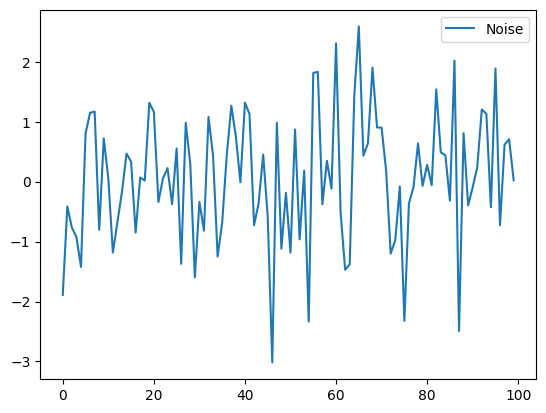

In [ ]:
np.random.seed(35)
eps = np.random.randn(100)
fig, ax = plt.subplots(1, 1)
ax.plot(eps, label='Noise')
ax.legend()

## Random Walk

What if the noise keeps adding up? At every step of the way, we add new noise while keeping all the noise added so far.

That's a **random walk**.

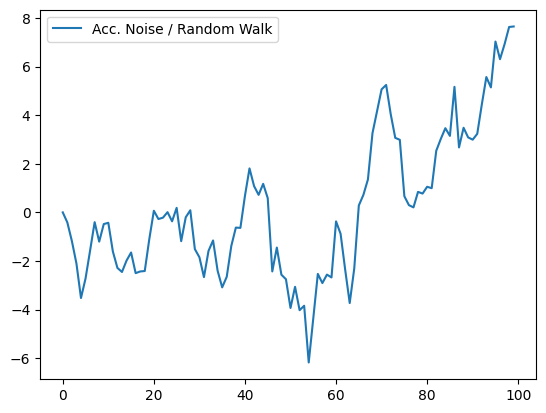

In [ ]:
series = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += series[t-1]
    series.append(new_value)

fig, ax = plt.subplots(1, 1)
ax.plot(series, label='Acc. Noise / Random Walk')
ax.legend()

## Random Walk with Drift

Now, what if we add some constant term at every step? That's a **drift**.

What does it look like?

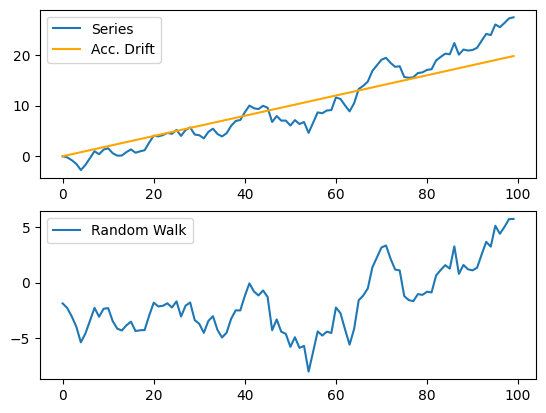

In [ ]:
series = [0]
drift = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += series[t-1]
    new_value += .2
    series.append(new_value)

    drift.append(drift[-1]+.2)

fig, axs = plt.subplots(2, 1)
axs[0].plot(series, label='Series')
axs[0].plot(drift, label='Acc. Drift', c='orange')
axs[0].legend()
axs[1].plot(eps.cumsum(), label='Random Walk')
axs[1].legend()

Adding a drift term made the random walk tilt upwards. It surely does look like it is **trending**, doesn't it?

## Random Walk with Trend

Even though the drift term made the plot look like it has a trend in it, it is not - technically speaking - a trend.

A **trend** is a term that **depends on time *t***.

So, let's add one of those (and remove the drift, so we observe the effect of a trend term alone).

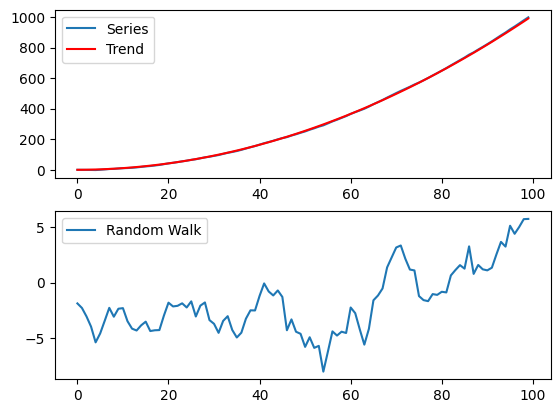

In [ ]:
series = [0]
trend = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += series[t-1]
    new_value += .2*t
    series.append(new_value)

    trend.append(trend[-1]+.2*t)

fig, axs = plt.subplots(2, 1)
axs[0].plot(series, label='Series')
axs[0].plot(trend, label='Trend', c='r')
axs[0].legend()
axs[1].plot(eps.cumsum(), label='Random Walk')
axs[1].legend()

WHOA! Now we're growing more than linearly!

In a way, it makes sense, since at every step *t*, we're adding **0.2\*t** to the series.

At t=1, we have 0.2. At t=2, we have 0.6 (0.2+0.4). At t=3, we have 1.2 (0.2+0.4+0.6). See where this is going?

But, shouldn't it be behaving like, well, a **trend** instead?

It should, but **only** if it's not a random walk anymore.

## AutoRegressive (AR) Series

So far, we've been adding up raw noise terms.

Now, let's multiply the existing sum (from the previous step) by a factor, and only then add the current noise term.

We're building an auto-regressive series now. To be honest, a Random Walk *was* also an AR series, but it's (implied) multiplying factor was 1.0, which led to the trend term misbehaving.

Let's see what an AR series looks like:

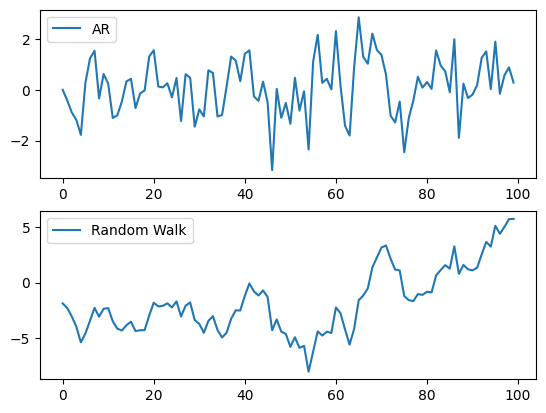

In [ ]:
series = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.3*series[t-1]
    series.append(new_value)

fig, axs = plt.subplots(2, 1)
axs[0].plot(series, label='AR')
axs[0].legend()
axs[1].plot(eps.cumsum(), label='Random Walk')
axs[1].legend()

Unlike the random walk, the AR series doesn't seem to be *going* anywhere. It's going back and forth around zero and that's good news for us.

I didn't tell you yet, but we're supposed to like and search for series like this: they are **stationary**, meaning they revolve around a given value (their mean) without departing too far away from it.

If you have studied ARIMA models at some point, we have probably already guessed where we're going with this. If you haven't, no worries, we'll get to them soon enough. For now, it should suffice to know that ARIMA models (and their extensions such as S-ARIMA-X models) are classical statistical models used to describe stationary time series.


****
This is the general notation of an ARIMA model:

$$
\Large
\text{ARIMA}(p, d, q)(P, D, Q, S)
$$

where:
- p = number of AR terms
  - eg. p=2 means using t-1 and t-2 as features
- d = number of times the series must be differentiated to become stationary
  - 0 means no differencing
  - 1 means series is transformed using (t-(t-1))
- q = number of MA terms (we'll get to them later)
  - eg. q=3 means using t-1, t-2, and t-3 as features
- S = number of periods of the seasonality
  - eg. S=12 in a monthly series means annual seasonality
  - eg. S=4 in a quaterly series also means annual seasonality
- P = number of seasonal AR terms
  - eg. P=2 means using T-S and T-2S as features
- D = number of times the series must be differentiated to become stationary
  - 0 means no differencing
  - 1 means series is transformed using (t-(t-S))
- Q = number of seasonal MA terms
  - eg. Q=3 means using T-S, T-2S, and T-3S as features
****

By "guessing" the number of auto-regressive terms involved in the series (ours had only one), the fitted model estimates their corresponding coefficients - the multiplying factor we used.

Let's use statsmodel's ARIMA model to see if it the estimated coefficient matches the true one (0.3):

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -147.573
Date:                Sun, 26 Jan 2025   AIC                            301.146
Time:                        16:14:28   BIC                            308.962
Sample:                             0   HQIC                           304.309
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1083      0.152      0.713      0.476      -0.190       0.406
ar.L1          0.2944      0.102      2.891      0.004       0.095       0.494
sigma2         1.1193      0.154      7.268      0.0

The number we're looking for is that `ar.L1` coefficient (0.2944) which stands for auto-regressive (`ar`) term for lag #1 (`L1`). Don't mind the plethora of information available in the summary, we're focusing on the coefficients only for now.

We can also try different values for the multiplier, such as a negative one:

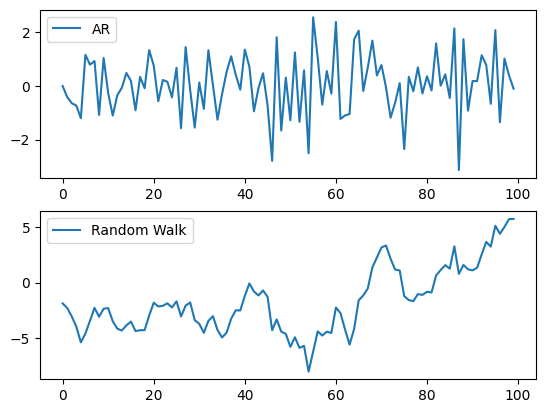

In [ ]:
series = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += -0.3*series[t-1]
    series.append(new_value)

fig, axs = plt.subplots(2, 1)
axs[0].plot(series, label='AR')
axs[0].legend()
axs[1].plot(eps.cumsum(), label='Random Walk')
axs[1].legend()

The negative multiplier produced a more *jagged* series of values, which is expected, since a negative multiplier will flip the sign back and forth.

Can the ARIMA model estimate it as well?

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -147.545
Date:                Sun, 26 Jan 2025   AIC                            301.091
Time:                        16:14:33   BIC                            308.906
Sample:                             0   HQIC                           304.254
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0592      0.082      0.725      0.468      -0.101       0.219
ar.L1         -0.3214      0.090     -3.572      0.000      -0.498      -0.145
sigma2         1.1184      0.154      7.270      0.0

Sure it can!

### AutoRegressive is Linear Regression

In [ ]:
import pandas as pd
df = pd.Series(series).to_frame('y')
df['lag1'] = df['y'].shift(1)
df.dropna(inplace=True)
df

,y,lag1
1,-0.413592,0.000000
2,-0.641948,-0.413592
3,-0.731542,-0.641948
4,-1.202135,-0.731542
5,1.165897,-1.202135
...,...,...
95,2.086741,-0.663378
96,-1.353382,2.086741
97,1.023115,-1.353382
98,0.401852,1.023115


In [ ]:
from sklearn.linear_model import LinearRegression

linr = LinearRegression()
linr.fit(y=df[['y']].values, X=df[['lag1']].values)

LinearRegression()

In [ ]:
linr.coef_, linr.intercept_

(array([[-0.32458303]]), array([0.0787636]))

## AutoRegressive with Drift

Last time, we added a *drift* component to a random walk and we got something that looked like a trend. What happens if we add a drift component to a true AR series?

Let's find out!

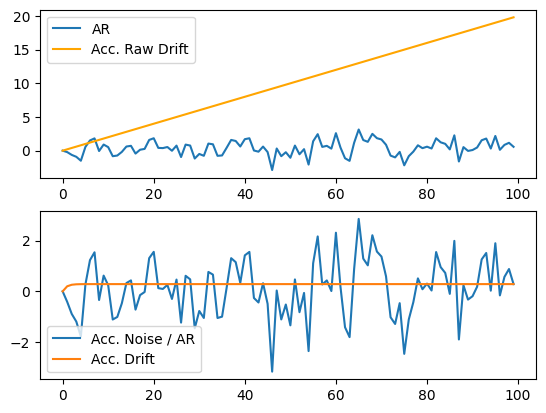

In [ ]:
series = [0]
drift = [0]
drift_ar = [0]
eps_ar = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.3*series[t-1]
    new_value += 0.2
    series.append(new_value)

    drift.append(drift[-1]+.2)
    drift_ar.append(.3*drift_ar[-1]+.2)
    eps_ar.append(.3*eps_ar[-1]+eps[t])

fig, axs = plt.subplots(2, 1)
axs[0].plot(series, label='AR')
axs[0].plot(drift, label='Acc. Raw Drift', c='orange')
axs[0].legend()
axs[1].plot(eps_ar, label='Acc. Noise / AR')
axs[1].plot(drift_ar, label='Acc. Drift')
axs[1].legend()

The "Acc. Raw Drift" shows the values being added up just like we saw it before. However, the actual AR series does not follow a trend anymore. Why is that?

As it turns out, the multiplier turns the drift component into a geometric progression! It quickly stabilizes around a value - which we can easily obtain by using the formula for the sum of an infinite geometric progression.

In [ ]:
# Geometric progression
.2/(1-.3), drift_ar[-1]

(0.28571428571428575, 0.2857142857142857)

If we estimated the same AR(1) model again, the coefficient `ar.L1` barely budged (it was 0.2944) but the constant - which is the *mean* of the series - got a bit higher thanks to the drift term.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,0,0)) # (p=AR, d, q=MA)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -147.632
Date:                Sun, 26 Jan 2025   AIC                            301.264
Time:                        16:14:49   BIC                            309.079
Sample:                             0   HQIC                           304.427
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3888      0.152      2.552      0.011       0.090       0.688
ar.L1          0.2967      0.102      2.918      0.004       0.097       0.496
sigma2         1.1206      0.154      7.259      0.0

## AutoRegressive with Trend

It's time to test the auto-regressive model using the same *trend* term as before.

Let's see how it goes!

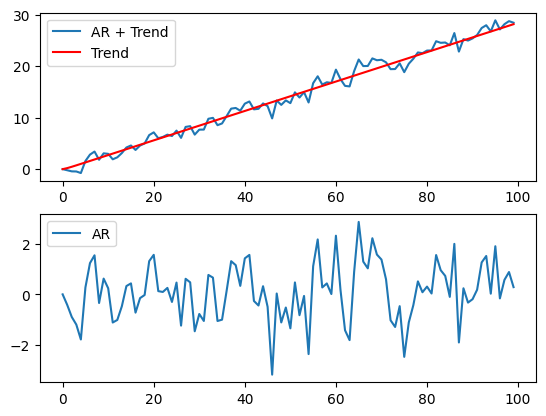

In [ ]:
series = [0]
trend_ar = [0]
eps_ar = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.3*series[t-1]
    new_value += 0.2*t
    series.append(new_value)

    trend_ar.append(.3*trend_ar[-1]+.2*t)
    eps_ar.append(.3*eps_ar[-1]+eps[t])

fig, axs = plt.subplots(2, 1)
axs[0].plot(series, label='AR + Trend')
axs[0].plot(trend_ar, label='Trend', c='r')
axs[0].legend()
axs[1].plot(eps_ar, label='AR')
axs[1].legend()

Much better! It produced a linear trend this time - just what the doctor prescribed!

Unlike the bare AR model (depicted in the 2nd plot), the AR model with a trend term does not revolve around a given value anymore.

We *lost* stationarity. What happens to the ARIMA model then? Let's find out.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -174.158
Date:                Sun, 26 Jan 2025   AIC                            354.316
Time:                        16:14:55   BIC                            362.132
Sample:                             0   HQIC                           357.479
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1453     10.336      1.369      0.171      -6.112      34.403
ar.L1          0.9940      0.017     58.222      0.000       0.961       1.028
sigma2         1.8238      0.256      7.128      0.0

<center><h2>YOU CAN'T HANDLE THE TREND!</h2></center>

<center><h5>Col. Nathan Jessup</h5></center>

![](https://i.imgflip.com/8eqh9o.jpg)

In order to actually handle the trend, we first have to see if it's there!

Sure, it's easy to just *take a look*, but how can we tell if there's a trend (as faint as it may be) - statistically speaking?

Let's run some **tests**, obviously!

### KPSS Test

> KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
>
> Null Hypothesis: The process is trend stationary.
>
> Alternate Hypothesis: The series has a unit root (series is not stationary).
>
> A function is created to carry out the KPSS test on a time series.
>
> [Source: Statsmodels' Documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#KPSS-test)

In the KPSS test, if the **p-value is low**, we reject the null hypothesis - so the series **IS NOT stationary** (there is a trend in it).

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_stat, pval, lags, crit_vals = kpss(series, regression='c', nlags='auto', store=False)
kpss_stat, pval

<ipython-input-18-7408e9d0d4a5>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, pval, lags, crit_vals = kpss(series, regression='c', nlags='auto', store=False)


(1.7614290412657003, 0.01)

It checks out, right? A p-value of 0.01 tells us that the series is not stationary.

Would it be stationary, if there was no (linear) trend? We can actually test this out by setting the `regression` argument to `ct`:

In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_stat, pval, lags, crit_vals = kpss(series, regression='ct', nlags='auto', store=False)
kpss_stat, pval

<ipython-input-19-619d1da9efea>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, pval, lags, crit_vals = kpss(series, regression='ct', nlags='auto', store=False)


(0.034053304130972024, 0.1)

A p-value of 0.10 isn't low enough to reject the null hypothesis so, once the linear trend is removed, the series is, in fact, stationary.

The function below is adapted from statsmodels' documentation to include a parameter for the regression argument:

In [ ]:
from statsmodels.tsa.stattools import kpss
import pandas as pd

def kpss_test(timeseries, regression='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(series)

Results of KPSS Test:
Test Statistic           1.761429
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-20-6d19d40d928a>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags="auto")


### Augmented Dickey Fuller Test

> ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
>
> Null Hypothesis: The series has a unit root.
>
> Alternate Hypothesis: The series has no unit root.
>
> If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.
>
> [Source: Statsmodels' Documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#ADF-test)

Another test for stationarity is the ADF test. The only problem is, the null and alternate hypotheses are actually **flipped** when compared to the KPSS test. This may be a source of confusion and misinterpretation, so make sure to always **check what the null hypothesis of the test is**.

In the ADF test, a **low p-value** - rejecting the null hypothesis - means that the **series IS stationary**. The ADF test also includes a `regression` argument we can use to try removing the linear trend. The function below is also adapted from statsmodels' documentation:

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, regression='c'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression=regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

If we run the ADF test, we'll get the following:

In [ ]:
adf_test(series, 'c'), adf_test(series, 'ct')

Results of Dickey-Fuller Test:
Test Statistic                  0.122052
p-value                         0.967535
#Lags Used                      8.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -5.088499
p-value                         0.000142
#Lags Used                      6.000000
Number of Observations Used    93.000000
Critical Value (1%)            -4.059569
Critical Value (5%)            -3.458800
Critical Value (10%)           -3.155334
dtype: float64


(None, None)

The raw series produces a p-value of 0.96, therefore the null hypothesis - NOT stationary - is likely true.

But, using the regression argument to remove the linear trend results in a p-value of 0.0001, therefore rejecting the null hypothesis - the series IS stationary then.

### Detrending vs Differencing

We've talked about removing the trend to assess the stationarity of the resulting - detrended - series. However, this is not the only way of turning a non-stationary series into a stationary one.

You'll see that it's fairly common to talk about differentiating a time series. As the  name suggests, it is nothing but simply taking the difference between two time steps. In Pandas, you can do that by simply calling the `diff()` method.

In [ ]:
pd.Series(series), pd.Series(series).diff()

(0      0.000000
 1     -0.213592
 2     -0.430104
 3     -0.453158
 4     -0.757545
         ...    
 95    28.916280
 96    27.147524
 97    28.161358
 98    28.757194
 99    28.447821
 Length: 100, dtype: float64,
 0          NaN
 1    -0.213592
 2    -0.216511
 3    -0.023054
 4    -0.304387
         ...   
 95    2.154441
 96   -1.768756
 97    1.013834
 98    0.595836
 99   -0.309373
 Length: 100, dtype: float64)

See? When you differentiate a time series, it will become a series of, well, the differences. It's easy to observe the result from the second time step onward. The first element in a differentiated time series will be `NaN` because there was no previous value to take the difference.

Statsmodels also offers a `diff()` method which can be applied to a time series. The argument `k_diff` specifies the number of differences to take. For the example above, K would be one since we took a single difference. If the resulting time series were *still* not stationary, we could take yet another difference (that is, a difference of differences).

The other two arguments refer to seasonality, which we'll discuss shortly. But, as you can probably guess, they allow us to take differences `seasonal_periods` apart: like taking the difference between two values corresponding to December, 12 months apart from each other.

Also, it's important to highlight that *differencing* and *detrending*, although both used to make a time series stationary, yield different results:

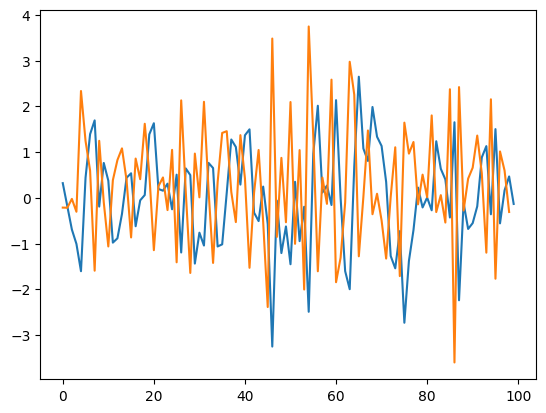

In [ ]:
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.statespace.tools import diff
series_det = detrend(np.array(series), order=1)
series_diff = diff(np.array(series), k_diff=1, k_seasonal_diff=None, seasonal_periods=1)
plt.plot(series_det)
plt.plot(series_diff)

As we can see, the differences match those we got using Pandas:

In [ ]:
np.all(pd.Series(series).diff().values[1:] == series_diff)

True

Differencing was easy. But how does one actually detrend a time series? If we dig inside the code of the `detrend()` method from statsmodels, we'll find the following:

In [ ]:
x = np.array(series)
nobs = len(x)
order = 1

# Inside detrend
trends = np.vander(np.arange(float(nobs)), N=order + 1)
beta = np.linalg.pinv(trends).dot(x)
resid = x - np.dot(trends, beta)

beta

array([ 0.29194717, -0.32114639])

That's a lot of linear algebra there, right? But it's nothing but a simple linear regression:

In [ ]:
# SkLearn Linear Regression
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X=np.arange(nobs).reshape(-1,1), y=x.reshape(-1,1))

linr.coef_, linr.intercept_,

(array([[0.29194717]]), array([-0.32114639]))

See? Matching coefficient and intercept. Detrending simply fits a linear regression, and then subtracts the resulting predicted values from the original series:

In [ ]:
trend = linr.predict(np.arange(nobs).reshape(-1, 1))
np.allclose((x - trend.squeeze()), series_det)

True

What happens now if we try to fit the ARIMA model to the detrended time series? It is stationary, so it should work just fine this time:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series_det, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -146.829
Date:                Sun, 26 Jan 2025   AIC                            299.659
Time:                        16:15:21   BIC                            307.474
Sample:                             0   HQIC                           302.822
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.148      0.005      0.996      -0.290       0.291
ar.L1          0.2744      0.103      2.673      0.008       0.073       0.476
sigma2         1.1029      0.150      7.345      0.0

And it does!

Alternatively, we could also use the original (non-stationary) series and tell the ARIMA model to use a linear trend (so we don't have to detrend it ourselves):

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,0,0), trend='t')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -148.840
Date:                Sun, 26 Jan 2025   AIC                            303.680
Time:                        16:15:23   BIC                            311.495
Sample:                             0   HQIC                           306.843
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2828      0.003    105.792      0.000       0.278       0.288
ar.L1          0.3260      0.101      3.233      0.001       0.128       0.524
sigma2         1.1477      0.159      7.228      0.0

Not quite the same result for the AR coefficient (even though the ballpark is the same). However, notice that `x1` and the `const` from last fit are different.

What if we tell the ARIMA model to differentiate the series instead?

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -165.565
Date:                Sun, 26 Jan 2025   AIC                            335.131
Time:                        16:15:25   BIC                            340.321
Sample:                             0   HQIC                           337.231
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3003      0.078     -3.829      0.000      -0.454      -0.147
sigma2         1.6585      0.246      6.743      0.000       1.176       2.141
Ljung-Box (L1) (Q):                   1.89   Jarque-

Interestingly, the AR coefficient is negative now, even though its absolute value is roughly the same as the one we used to generate the series (and those estimated using a detrended series).

## AutoRegressive with Trend and Seasonality

> To everything, turn, turn, turn
> There is a season, turn, turn, turn
>
> Turn! Turn! Turn! (To Everything There Is A Season), from The Byrds

It's often the case that a time series does not only exhibit a trend but also a seasonality. Think of the typical example of ice cream sales. You can expect more ice cream to be sold during summer than winter, right? Even if the overall market grows from one year to the next, it's very likely that current winter sales are still lower than previous summer sales. If that's the case, the time series is seasonal.

Let's add a simple sine wave with a period of 12 time intervals to our mix:

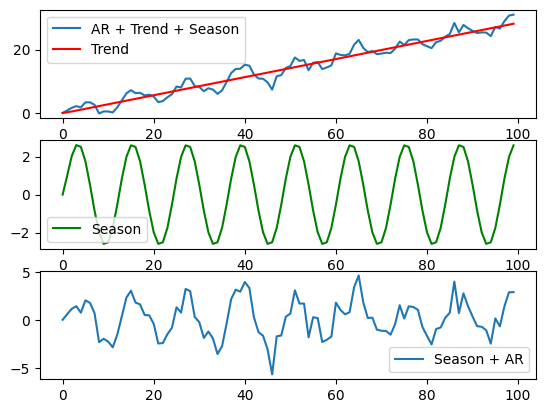

In [ ]:
series = [0]
trend_ar = [0]
eps_ar = [0]
season_ar = [0]

for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.3*series[t-1] # AR
    new_value += 0.2*t # Trend
    new_value += 2*np.sin(2*np.pi*t/12) # Seasonality
    series.append(new_value)

    trend_ar.append(.3*trend_ar[-1]+.2*t)
    eps_ar.append(.3*eps_ar[-1]+eps[t])
    season_ar.append(.3*season_ar[-1]+2*np.sin(2*np.pi*t/12))

fig, axs = plt.subplots(3, 1)
axs[0].plot(series, label='AR + Trend + Season')
axs[0].plot(trend_ar, label='Trend', c='r')
axs[0].legend()
axs[1].plot(season_ar, label='Season', c='g')
axs[1].legend()
axs[2].plot(np.array(season_ar)+np.array(eps_ar), label='Season + AR')
axs[2].legend()

As you can see in the plot at the bottom, the resulting series has both the ups and downs of the sine wave (season) and the oscillations of the AR series we've been using so far.

In the top plot, you can see the effect of adding a trend to it.

What if we detrend the series?

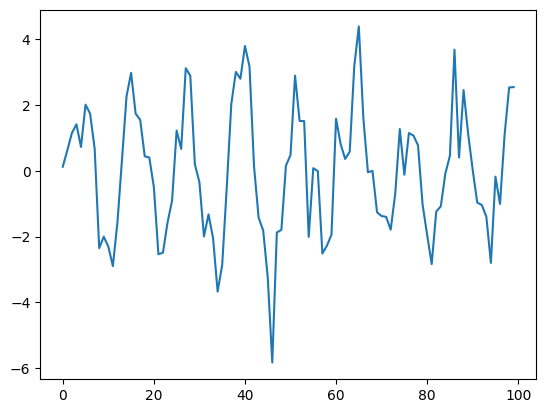

In [ ]:
series_det = detrend(np.array(series), order=1)
plt.plot(series_det)

As you probably guessed, we retrieved the other two components: AR and season.

What happens if we estimate an ARIMA model using this detrended (yet seasonal) series?

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series_det, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -177.526
Date:                Sun, 26 Jan 2025   AIC                            361.052
Time:                        16:15:33   BIC                            368.867
Sample:                             0   HQIC                           364.215
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0533      0.441      0.121      0.904      -0.810       0.917
ar.L1          0.6752      0.071      9.469      0.000       0.535       0.815
sigma2         2.0270      0.314      6.448      0.0

Although our AR component has a coefficient of 0.3, the estimated model placed it at nearly 0.7. Clearly, seasonality got in the way of the proper estimation.

Well, we can account for seasonality in the ARIMA model as well. Of course, our seasonality isn't quite autoregressive (we used a sine wave for it), but we can try it out with a yearly seasonality nonetheless.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series_det, order=(1,0,0), seasonal_order=(1,0,0,12)) # (P, D, Q, S)
model_fit = model.fit()
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  100
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -167.666
Date:                          Sun, 26 Jan 2025   AIC                            343.331
Time:                                  16:15:35   BIC                            353.752
Sample:                                       0   HQIC                           347.549
                                          - 100                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0613      0.478      0.128      0.898      -0.875       0.998
ar.L1          0.5095      0.092      5.537      0.

In our example, we know for a fact that the seasonality was 12 time intervals because we built it. Yearly seasonality is generally a good guess, especially when dealing with time series in economics.

However, how can we try to better determine if there is a seasonality (apart from taking a look at it) and which periodicity it has?

We can take a look at the autocorrelations in the series!

### Autocorrelation

In [ ]:
def acf_py(x, lags):
    x = np.array(x)
    # Mean
    mean = np.mean(x)
    # Variance
    var = np.var(x)
    # Centered data
    ndata = x - mean

    # Using Numpy correlate
    # acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:]
    # Manually
    acorr = [0]*lags
    # Go through lag components one-by-one
    for l in range(lags):
        c = var * len(ndata) # Self correlation
        if (l > 0):
            c = sum([ndata[l:][i] * ndata[:-l][i] for i in range(len(x) - l)])
        acorr[l] = c
    acorr = np.array(acorr)

    acorr = acorr / var / len(ndata)
    return np.array(acorr)[:lags]

In [ ]:
acf_val = acf_py(series_det, 24)
acf_val

array([ 1.        ,  0.67006364,  0.35355071, -0.01318811, -0.30324806,
       -0.60360358, -0.73409013, -0.63731757, -0.33554856,  0.02005666,
        0.2942953 ,  0.51600007,  0.6299107 ,  0.55026014,  0.25777041,
       -0.04997569, -0.35136017, -0.52503806, -0.56370188, -0.4857093 ,
       -0.25417746,  0.05109088,  0.30099382,  0.50267077])

In [ ]:
from statsmodels.tsa.stattools import acf

acf(series_det, nlags=30)

array([ 1.        ,  0.67006364,  0.35355071, -0.01318811, -0.30324806,
       -0.60360358, -0.73409013, -0.63731757, -0.33554856,  0.02005666,
        0.2942953 ,  0.51600007,  0.6299107 ,  0.55026014,  0.25777041,
       -0.04997569, -0.35136017, -0.52503806, -0.56370188, -0.4857093 ,
       -0.25417746,  0.05109088,  0.30099382,  0.50267077,  0.55237191,
        0.44804796,  0.23578307, -0.0068656 , -0.24796982, -0.46739822,
       -0.51021653])

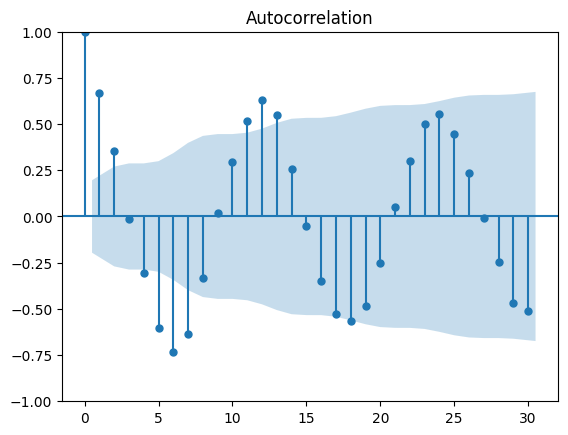

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(np.array(series_det), lags=30);

## AutoRegressive with Trend and Cycle

Sometimes, there's a longer cycle instead of a well-defined seasonality. We can illustrtate such cycle by adding a sine wave of 75 time intervals (we're keeping seasonality out of the picture for now).

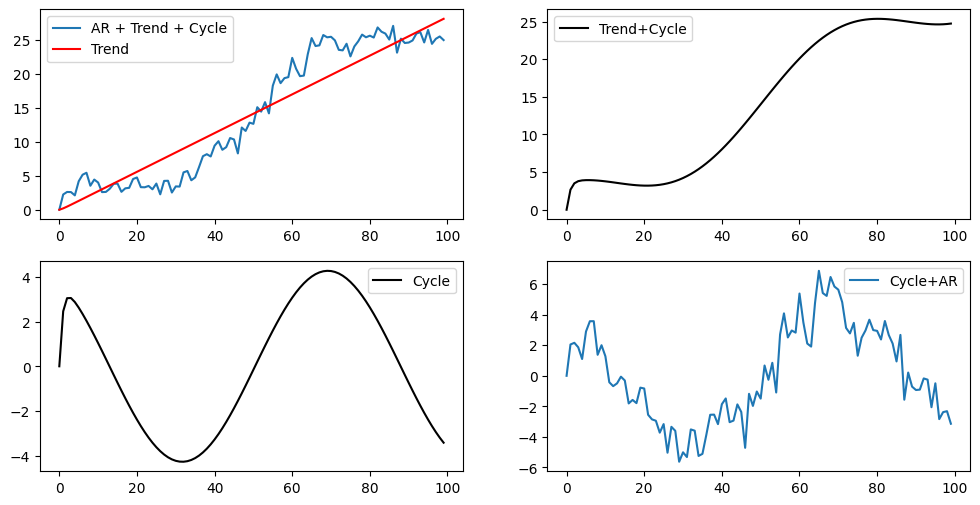

In [ ]:
series = [0]
trend_ar = [0]
eps_ar = [0]
cycle_ar = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.3*series[t-1]
    new_value += 0.2*t
    new_value += 3*np.sin(2*np.pi*(t-50)/75)
    series.append(new_value)

    trend_ar.append(.3*trend_ar[-1]+.2*t)
    eps_ar.append(.3*eps_ar[-1]+eps[t])
    cycle_ar.append(.3*cycle_ar[-1]+3*np.sin(2*np.pi*(t-50)/75))

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.flatten()
axs[0].plot(series, label='AR + Trend + Cycle')
axs[0].plot(trend_ar, label='Trend', c='r')
axs[0].legend()
axs[1].plot(np.array(trend_ar)+np.array(cycle_ar), label='Trend+Cycle', c='k')
axs[1].legend()
axs[2].plot(cycle_ar, label='Cycle', c='k')
axs[2].legend()
axs[3].plot(np.array(eps_ar)+np.array(cycle_ar), label='Cycle+AR')
axs[3].legend()

Just like seasonality, the longer cycle created the underlying up and down upon which the oscillations of the AR process happened. We can also combine both trend and cycle to get the overall movement over time.

## AutoRegressive with Trend, Cycle, and Seasonality

It's finally the time to put everything together: trend, cycle, and seasonality.

These are the main components of real time series, and they are usually split into seasonality, trend and cycle, and the noisy random part (also called the "innovations").

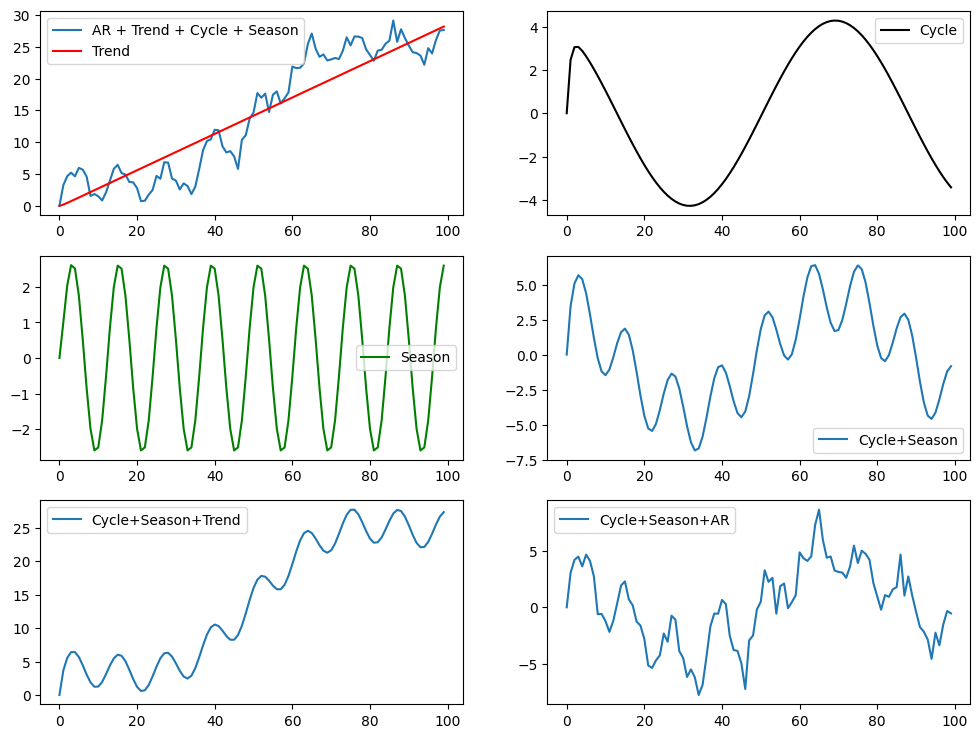

In [ ]:
series = [0]
trend_ar = [0]
eps_ar = [0]
cycle_ar = [0]
season_ar = [0]

for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.3*series[t-1] # AR
    new_value += 0.2*t # Trend
    new_value += 3*np.sin(2*np.pi*(t-50)/75) # Cycle
    new_value += 2*np.sin(2*np.pi*t/12) # Season
    series.append(new_value)

    trend_ar.append(.3*trend_ar[-1]+.2*t)
    eps_ar.append(.3*eps_ar[-1]+eps[t])
    cycle_ar.append(.3*cycle_ar[-1]+3*np.sin(2*np.pi*(t-50)/75))
    season_ar.append(.3*season_ar[-1]+2*np.sin(2*np.pi*t/12))

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()
axs[0].plot(series, label='AR + Trend + Cycle + Season')
axs[0].plot(trend_ar, label='Trend', c='r')
axs[0].legend()
axs[1].plot(cycle_ar, label='Cycle', c='k')
axs[1].legend()
axs[2].plot(season_ar, label='Season', c='g')
axs[2].legend()
axs[3].plot(np.array(cycle_ar)+np.array(season_ar), label='Cycle+Season')
axs[3].legend()
axs[4].plot(np.array(cycle_ar)+np.array(season_ar)+np.array(trend_ar), label='Cycle+Season+Trend')
axs[4].legend()
axs[5].plot(np.array(cycle_ar)+np.array(season_ar)+np.array(eps_ar), label='Cycle+Season+AR')
axs[5].legend()

We explored AR processes in detail, but they're not the only type of process we're seeing when it comes to time series. If the AR process is defined by relying on previous values (lags) of the time series itself, its counterpart - the moving average process (MA for short) is defined by relying on innovations (or errors) of the past.

## MA

This component is **NOT** a rolling average, but rather a weighted sum of previous values (lags) in the noise (innovations).

Here is a list of real-world examples of such processes: https://stats.stackexchange.com/questions/45026/real-life-examples-of-moving-average-processes

Also, from [this video](https://www.youtube.com/watch?v=voryLhxiPzE) comes a simple and funny example about cupcakes. We're using an adapted version found on [this post](https://towardsdatascience.com/a-deep-dive-on-arima-models-8900c199ccf).

### The Cupcake Party

Let's say you really like to bake cupcakes. So, you decide to make a tray of 10 cupcakes because it's easy enough to do, and it fits nicely into your oven. You want to give them away, so you decide to throw a small cupcake party every Wednesday to meet new people. You send invites to 10 people, so if everyone shows up, no one leaves empty-handed. If there are fewer people than cupcakes, some people will get to eat more than one of your delicious cupcakes.

- First party: Only 8 people show up. You made 2 cupcakes too many, but two lucky people get to eat them, and they are pretty happy about it. So, you wonder: "Perhaps I should make only 8 cupcakes next time. But, to be on the safe side, I will split the difference, and make 9 instead (your average 10 minus half the difference)."

- Second party: Now, 12 people show up. Those two people were so happy that they got 2 cupcakes that they spread the word and invited their friends too. Now, you're actually *missing* 3 cupcakes since you only made 9. Three people leave empty-handed and they're not thrilled about it. So, you think: "OK, no worries, I will make adjustments once again. I will split the difference, and make 11.5 cupcakes next time (your average 10 plus half the difference)."

You see where this is going, right? You'd like to cook 10 cupcakes each time, but you keep constantly adjusting for half the error you got in the last party you threw.

In the code below, we're using a zero mean - even though it doesn't make sense to throw a party to serve zero cupcakes on average - for the sake of simplicity.

Every new value is the last "noise" multiplied by 0.5. But, of course, there's a new error which is added to it (more or less people showed up than your adjusted expectation).

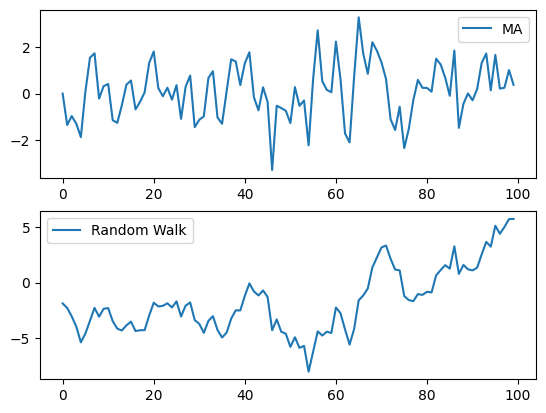

In [ ]:
series = [0]
for t in range(1, len(eps)):
    new_value = 0.5*eps[t-1]
    new_value += eps[t]
    series.append(new_value)

fig, axs = plt.subplots(2, 1)
axs = axs.flatten()
axs[0].plot(series, label='MA')
axs[0].legend()
axs[1].plot(eps.cumsum(), label='Random Walk')
axs[1].legend()

In [ ]:
from scipy import optimize

data = series
mu_estimated = np.mean(data)

# create function to calculate mse
def error_mse(coefs):
    n_parms = len(coefs)
    coefs = np.array(coefs)

    estimated_errors = (np.array(data) - mu_estimated)

    for i in range(1, len(data)):
#         if i > 1:
#             estimated_errors[i] += coefs[0] * estimated_errors[i-1]
#         if i > 2:
#             estimated_errors[i] += coefs[1] * estimated_errors[i-2]
#         if i > 3:
#             ...
        estimated_errors[i] += (coefs[:i][::-1] * estimated_errors[i-min(i, n_parms):i]).sum()

    return (np.array(estimated_errors) ** 2).mean()

# find coefficient θ
initial_guess = [0]
result = optimize.minimize(error_mse, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[-0.46886862]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data, order=(0,0,1)) # p (AR), d, q (MA)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -148.140
Date:                Sun, 26 Jan 2025   AIC                            302.280
Time:                        16:15:58   BIC                            310.095
Sample:                             0   HQIC                           305.443
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1068      0.159      0.670      0.503      -0.206       0.419
ma.L1          0.4660      0.084      5.534      0.000       0.301       0.631
sigma2         1.1303      0.157      7.187      0.0

Can you tell the difference between an AR and an MA process just by looking at the plot? Me neither!

And, even worse, they may happen simultaneously! Enter the ARMA process!

## ARMA

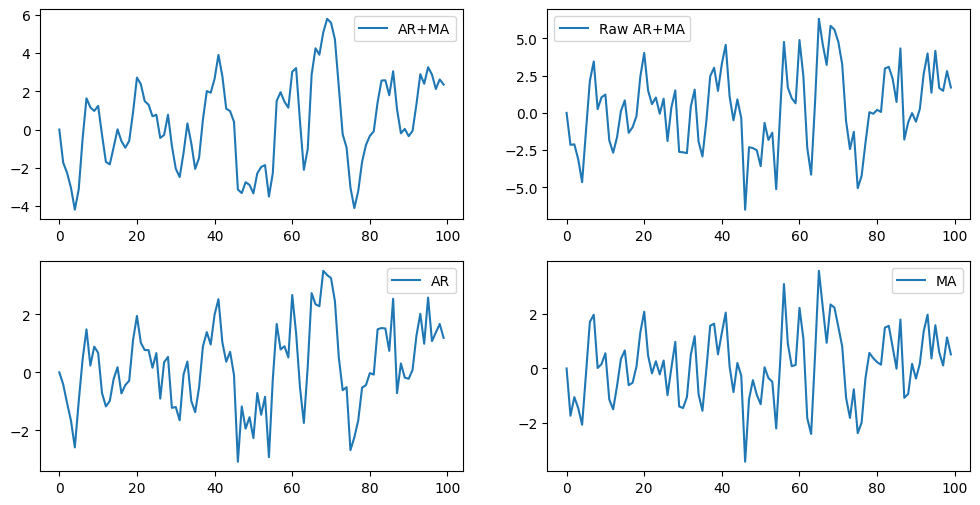

In [ ]:
series = [0]
ar = [0]
ma = [0]
eps_ar = [0]
for t in range(1, len(eps)):
    new_value = eps[t]
    new_value += 0.7*series[t-1] # AR
    new_value += 0.7*eps[t-1] # MA
    series.append(new_value)
    ar.append(.7*ar[-1]+eps[t])
    ma.append(.7*eps[t-1]+eps[t])

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.flatten()
axs[0].plot(series, label='AR+MA')
axs[0].legend()
axs[1].plot(np.array(ar)+np.array(ma), label='Raw AR+MA')
axs[1].legend()
axs[2].plot(ar, label='AR')
axs[2].legend()
axs[3].plot(ma, label='MA')
axs[3].legend()

Not only it's extremely unlikely that you can tell those two apart, adding their raw values up (which is NOT what the ARMA process does) or generating a true ARMA series yields equally similar plots.

In our case, we know for a fact that we're using only a single AR and a single MA term. Let's see if the estimated ARIMA model can determine the right coefficients.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series, order=(1,0,1)) # p, d, q
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -149.031
Date:                Sun, 26 Jan 2025   AIC                            306.063
Time:                        16:16:08   BIC                            316.483
Sample:                             0   HQIC                           310.280
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3905      0.595      0.657      0.511      -0.775       1.556
ar.L1          0.6945      0.082      8.422      0.000       0.533       0.856
ma.L1          0.6595      0.075      8.833      0.0

That's pretty close!

## Choosing the Parameters with AIC

While the rules of thumb regarding ACF and PACF plots may give you a hint of which ARMA model to use, it is also commonplace to fit as many as you can (within reason) and choose the one with the highest goodness of fit.

Instead of the typical adjusted-R2 used in linear regression (where the higher the better), when it comes to ARMA models we'll use Akaike Information Criterion (AIC for short, and the lower the better in this case) to choose the best model.

Both adjusted-R2 and AIC are computed using the sum of squared errors (SSE), the number of observations (n) and the number of parameters in the model (K). The R2 computation also uses the total sum of squares (SST).

`adjusted-R2 = 1 - (SSE/(n-K)) / (SST/(n-1))`

`AIC = n * [log(2*pi) + log(SSE/n) + 1] + 2*K`

## Missing Values

In [ ]:
# https://github.com/jrnold/ssmodels-in-stan/tree/master/StanStateSpace/data-raw
# internet.dat Number of users logged on to an internet server

In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile

# Download the dataset
df = pd.read_table(
    "https://raw.githubusercontent.com/jrnold/ssmodels-in-stan/master/StanStateSpace/data-raw/DK-data/internet.dat",
    skiprows=1, header=None, sep='\s+', engine='python',
    names=['internet','dinternet']
)
df

,internet,dinternet
0,88,-9999.99
1,84,-4.00
2,85,1.00
3,85,0.00
4,84,-1.00
...,...,...
95,222,7.00
96,228,6.00
97,226,-2.00
98,222,-4.00


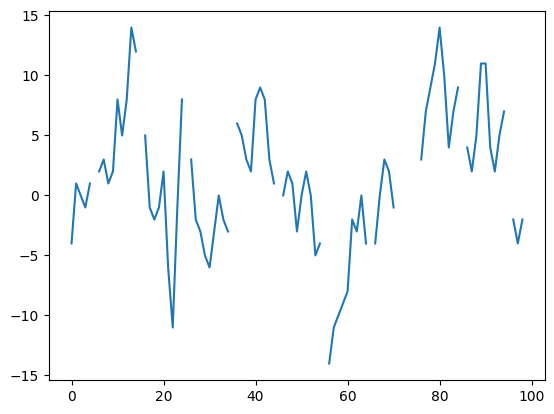

In [ ]:
# Get the basic series
dta_full = df.dinternet[1:].values
dta_miss = dta_full.copy()

# Remove datapoints
missing = np.r_[6,16,26,36,46,56,66,72,73,74,75,76,86,96]-1
dta_miss[missing] = np.nan
plt.plot(dta_miss)

In [ ]:
from scipy.stats import norm
import statsmodels.api as sm
import warnings

aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with missing datapoints
        mod = ARIMA(dta_miss, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit()
            aic_miss.iloc[p,q] = res.aic
        except:
            aic_miss.iloc[p,q] = np.nan

In [ ]:
aic_miss

,0,1,2,3,4,5
0,0.000000,487.319107,464.125773,464.319437,463.399256,464.545040
1,467.245038,458.822638,460.747598,460.225474,460.698623,462.507320
2,463.678526,460.808675,462.014398,461.010156,459.972799,461.352491
3,457.481036,459.480954,461.246499,458.095527,460.680630,461.548547
4,459.480915,461.153765,554.825586,459.883303,460.722284,462.450041
5,461.034500,462.848593,465.089856,466.468471,462.453639,462.497391


In [ ]:
mod = ARIMA(dta_miss, order=(1,0,1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -225.411
Date:                Sun, 26 Jan 2025   AIC                            458.823
Time:                        16:16:35   BIC                            469.203
Sample:                             0   HQIC                           463.023
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1488      1.402      0.820      0.412      -1.598       3.896
ar.L1          0.6395      0.093      6.859      0.000       0.457       0.822
ma.L1          0.4929      0.116      4.268      0.0

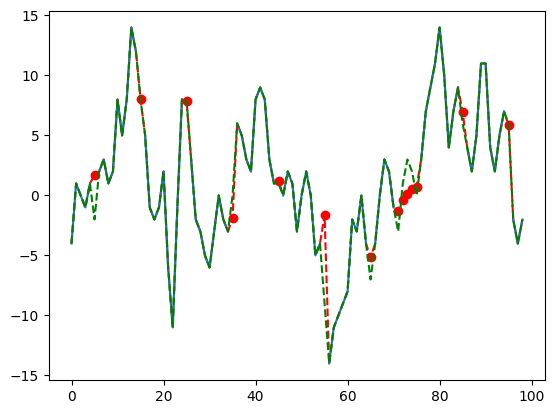

In [ ]:
plt.scatter(missing, res.fittedvalues[missing], c='r')
dta_filled = dta_miss.copy()
dta_filled[missing] = res.fittedvalues[missing]
plt.plot(dta_filled, c='r', linestyle='--')
plt.plot(dta_miss)
plt.plot(dta_full, c='g', linestyle='--')

## AutoARIMA

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.8 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

data = pm.datasets.load_wineind()
train, test = model_selection.train_test_split(data, train_size=150)

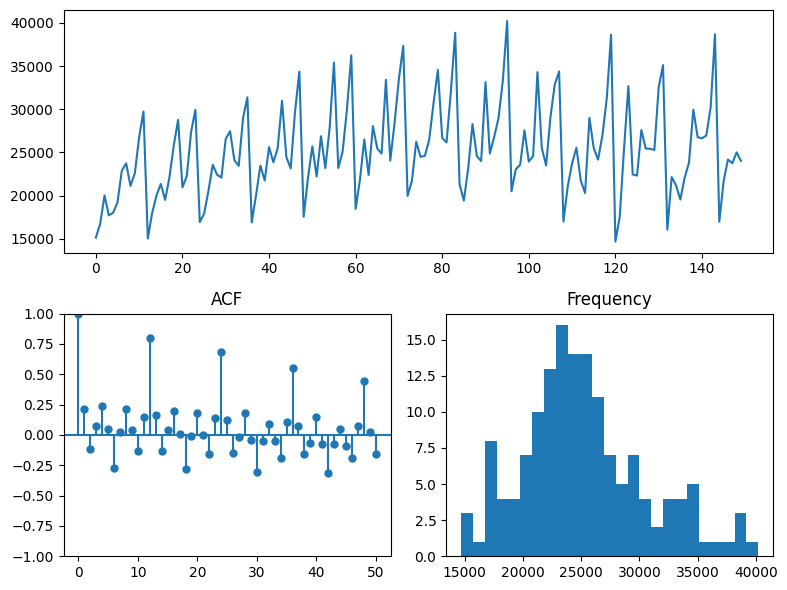

In [ ]:
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf as pm_plot_acf, plot_pacf as pm_plot_pacf
from pmdarima.arima import ADFTest, decompose

tsdisplay(train)

In [ ]:
ADFTest().should_diff(train)

(0.01, False)

In [ ]:
# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2915.873, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3049.597, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2954.975, Time=0.75 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2947.028, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3047.612, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2940.108, Time=1.12 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2915.651, Time=0.60 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2986.348, Time=0.37 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2915.275, Time=0.85 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2918.411, Time=2.60 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=2925.080, Time=1.51 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=2911.330, Time=3.14 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2911.555, Time=2.10 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=2914.196, Time=0.81 sec
 ARIMA(2,1,1)(1,0,1

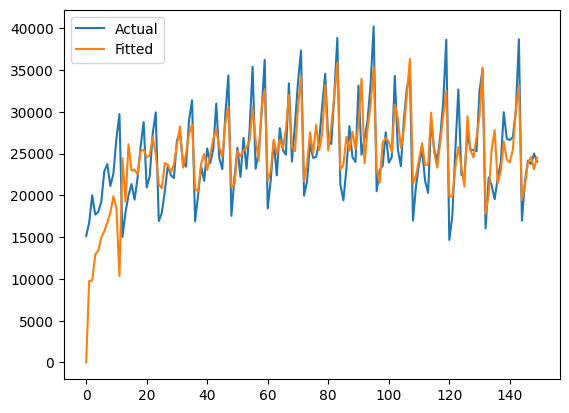

In [ ]:
x = np.arange(train.shape[0])
plt.plot(x, train, label='Actual')
plt.plot(x, arima.fittedvalues(), label='Fitted')
plt.legend()

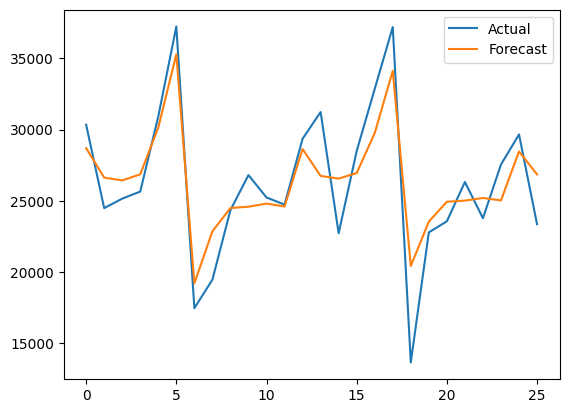

In [ ]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test, label='Actual')
plt.plot(x, arima.predict(n_periods=test.shape[0]), label='Forecast')
plt.legend()

In [ ]:
from pmdarima.metrics import smape
smape(test, arima.predict(n_periods=test.shape[0]))

8.204845042606047

## Wold's Decomposition Theorem

We're not going into details here, but perhaps you're wondering why time series are handled this way. As it turns out, there's something called [Wold's Decomposition Theorem](https://en.wikipedia.org/wiki/Wold%27s_theorem) which states that every *stationary* time series can be written as the **sum of two time series**: one deterministic and one stochastic.

It goes further to state that the deterministic part is completely determined by past values of the series itself (sounds like an AR?) and may include stationary deterministic terms (such as sine or cosine waves).

The stochastic part, on the other hand, given by a weighted moving average of past and present innovations (sounds like an MA?).

Given these characteristics, it should be no surprise that ARMA models and their extensions are at the core of time series forecasting techniques.

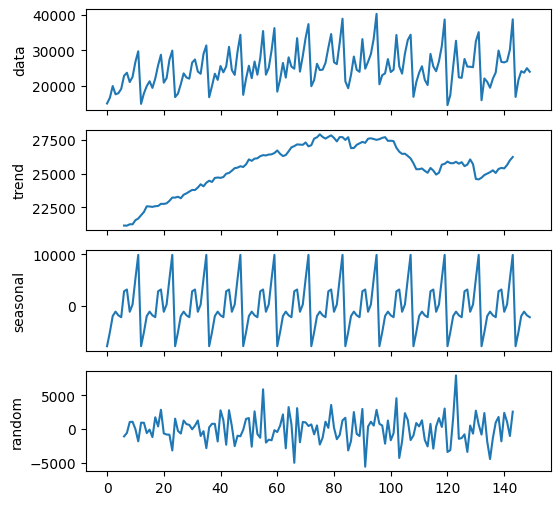

In [ ]:
decomposed = decompose(train, 'additive', m=12)
decomposed_plot(decomposed, figure_kwargs={'figsize': (6, 6)})